Step 1: Loading the QM9 Dataset
First, let's load the QM9 dataset using torch-geometric and perform some basic exploration.

In [4]:
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv
!pip install ase


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 57.9 MB/s eta 0:00:00


In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import QM9
from torch_geometric.transforms import Distance
from torch_geometric.nn import GINConv, GAE, VGAE
from torch_geometric.utils import train_test_split_edges
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Dataset preparation
from ase import Atoms
from ase.visualize import view


In [7]:
import torch
from torch_geometric.datasets import QM9

# Load the QM9 dataset
dataset = QM9(root='data/QM9')

# Check the size of the dataset
print(f"Number of molecules in the dataset: {len(dataset)}")

# Inspect the properties of a single molecule
print("Sample molecule data:\n", dataset[0])
print("Keys in the dataset:\n", dataset[0].keys)


Extracting data/QM9/raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
/usr/local/lib/python3.10/dist-packages/torch_geometric/datasets/qm9.py:215: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control

Number of molecules in the dataset: 130831
Sample molecule data:
 Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
Keys in the dataset:
 <bound method BaseData.keys of Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])>


Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/io/fs.py:215: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location)


Step 2: Basic Data Information
Let's inspect the properties (features) and labels provided in the QM9 dataset:

Features include atomic numbers, coordinates, and edge indices (bonds).
Labels include various molecular properties like energy, dipole moment, etc.

In [9]:
# Features and Labels
print("Number of features in QM9 dataset:", dataset.num_features)
print("Number of targets (labels) in QM9 dataset:", dataset.num_classes)



Number of features in QM9 dataset: 11
Number of targets (labels) in QM9 dataset: 19


Step 3: Visualizing Atomic Structures
Using the ASE (Atomic Simulation Environment) library, we can visualize the atomic structures of the molecules in the dataset.

In [10]:
from ase import Atoms
from ase.visualize import view

# Visualize the first molecule in the dataset
first_molecule = dataset[0]
positions = first_molecule.pos.cpu().numpy()  # atomic positions
atomic_numbers = first_molecule.z.cpu().numpy()  # atomic numbers

# Create an ASE Atoms object
atoms = Atoms(positions=positions, numbers=atomic_numbers)

# Visualize the molecule (opens in a viewer)
view(atoms)


<Popen: returncode: None args: ['/usr/bin/python3', '-m', 'ase', 'gui', '-']>

In [12]:
import torch
from torch_geometric.datasets import QM9

# Load the QM9 dataset
dataset = QM9(root='data/QM9')

# Check the number of molecules in the dataset
print(f"Number of molecules in the dataset: {len(dataset)}")

# Access the first molecule's data
print("Sample molecule data:\n", dataset[0])

# Inspect the target (property) of the first molecule
print("Target (molecular properties) of the first molecule:\n", dataset[0].y)

# Number of target properties
print(f"Number of target properties (molecular properties): {dataset.num_classes}")


/usr/local/lib/python3.10/dist-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.load(f) != _repr(self.p

Number of molecules in the dataset: 130831
Sample molecule data:
 Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
Target (molecular properties) of the first molecule:
 tensor([[    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
             1.2177, -1101.4878, -1101.4098, -1101.3840, -1102.0229,     6.4690,
           -17.1722,   -17.2868,   -17.3897,   -16.1519,   157.7118,   157.7100,
           157.7070]])
Number of target properties (molecular properties): 19


Step 1: Define the Correct Property Names

In [14]:
# Correct list of 19 property names
property_names = [
    'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv',
    'U_atom_1', 'U_atom_2', 'U_atom_3', 'U_atom_4', 'U_atom_5', 'U_atom_6', 'U_atom_7'
]


Step 2: Extract the Molecular Properties and Create DataFrame

In [15]:
import pandas as pd
import torch

# Extract the molecular properties from the dataset
properties = torch.cat([data.y for data in dataset], dim=0)

# Convert to a pandas DataFrame with 19 properties
df = pd.DataFrame(properties.numpy(), columns=property_names)

# Display the first few rows
print(df.head())


       mu      alpha       homo      lumo        gap         r2      zpve  \
0  0.0000  13.210000 -10.549854  3.186453  13.736308  35.364101  1.217682   
1  1.6256   9.460000  -6.993326  2.255824   9.249149  26.156300  0.934929   
2  1.8511   6.310000  -7.967494  1.869422   9.836916  19.000200  0.581643   
3  0.0000  16.280001  -7.741639  1.376896   9.118535  59.524799  0.730381   
4  2.8937  12.990000  -9.806983  0.519737  10.329442  48.747601  0.451736   

            U0            U            H            G     Cv   U_atom_1  \
0 -1101.487793 -1101.409790 -1101.384033 -1102.022949  6.469 -17.172182   
1 -1538.147705 -1538.069824 -1538.044189 -1538.666748  6.316 -12.005855   
2 -2079.077881 -2079.000732 -2078.975098 -2079.558105  6.002  -9.240362   
3 -2103.669434 -2103.590576 -2103.564697 -2104.186523  8.574 -16.716963   
4 -2541.866943 -2541.798340 -2541.772705 -2542.393555  6.278 -13.088188   

    U_atom_2   U_atom_3   U_atom_4    U_atom_5    U_atom_6    U_atom_7  
0 -17.286823 

Step 3: Plot Histograms for Selected Properties
Now you can plot the histograms for key properties, such as HOMO, LUMO, and Dipole Moment (mu), as before.

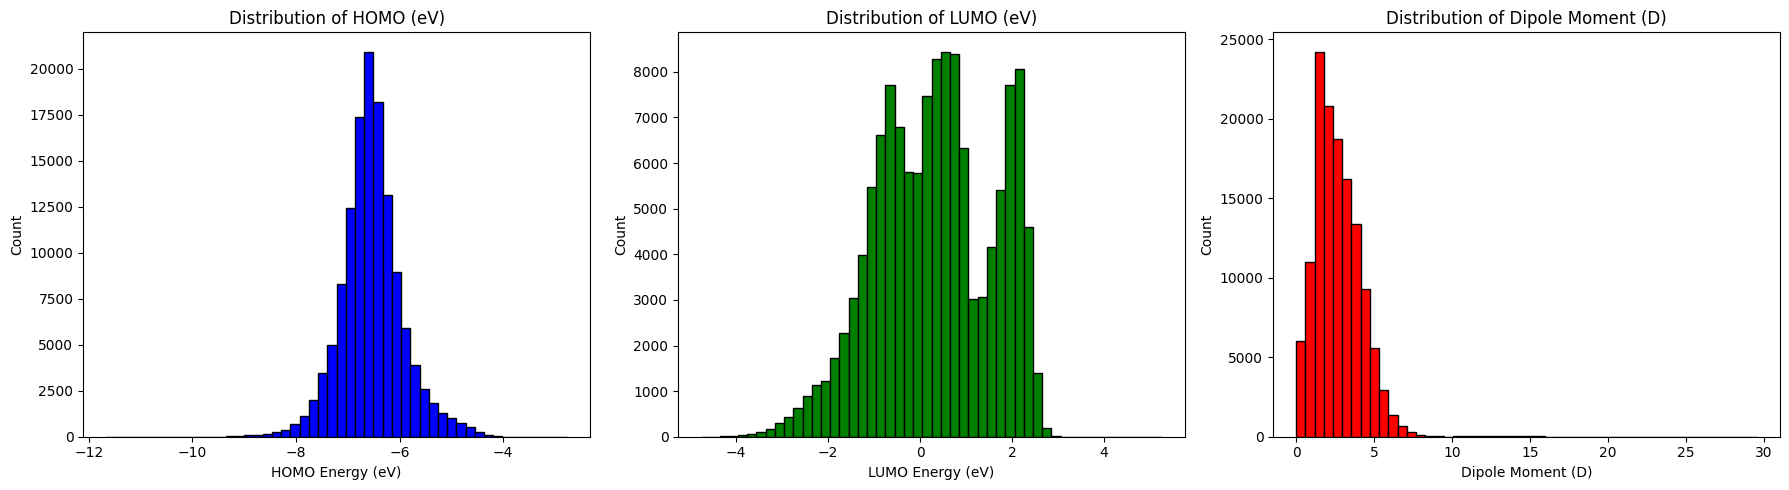

In [16]:
import matplotlib.pyplot as plt

# Plot histograms of HOMO, LUMO, and Dipole Moment
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# HOMO
ax[0].hist(df['homo'], bins=50, color='blue', edgecolor='black')
ax[0].set_title("Distribution of HOMO (eV)")
ax[0].set_xlabel("HOMO Energy (eV)")
ax[0].set_ylabel("Count")

# LUMO
ax[1].hist(df['lumo'], bins=50, color='green', edgecolor='black')
ax[1].set_title("Distribution of LUMO (eV)")
ax[1].set_xlabel("LUMO Energy (eV)")
ax[1].set_ylabel("Count")

# Dipole Moment
ax[2].hist(df['mu'], bins=50, color='red', edgecolor='black')
ax[2].set_title("Distribution of Dipole Moment (D)")
ax[2].set_xlabel("Dipole Moment (D)")
ax[2].set_ylabel("Count")

plt.tight_layout()
plt.show()


Step 4: Summary Statistics
To check summary statistics for selected properties, you can run:

In [17]:
# Summary statistics for key molecular properties
print(df[['homo', 'lumo', 'mu']].describe())


                homo           lumo             mu
count  130831.000000  130831.000000  130831.000000
mean       -6.536452       0.322044       2.672953
std         0.597741       1.274855       1.503479
min       -11.662800      -4.761992       0.000000
25%        -6.873596      -0.634025       1.577800
50%        -6.560665       0.342863       2.475300
75%        -6.228686       1.385060       3.596350
max        -2.767398       5.265403      29.556400


Step 3: Visualization of Molecular Properties
Here's an example of how to extract and visualize some of the properties, like HOMO, LUMO, and Dipole Moment (mu):

Step 4: Distribution of Molecular Properties
Let's plot the distribution of some key molecular properties such as HOMO (Highest Occupied Molecular Orbital energy) and LUMO (Lowest Unoccupied Molecular Orbital energy), Dipole Moment, etc.

Step 5: Correlation Between Properties
Next, we can calculate and visualize correlations between different molecular properties to see if any relationships exist.

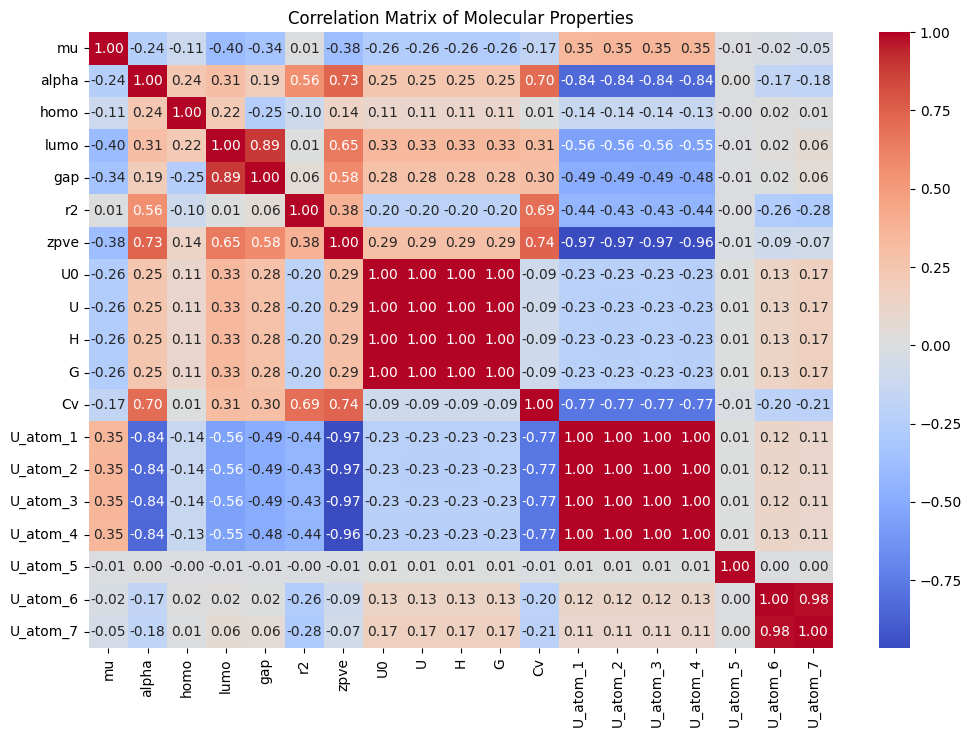

In [18]:
import seaborn as sns

# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Molecular Properties')
plt.show()


Step 6: Pairwise Scatter Plots
We can also visualize relationships between pairs of properties using scatter plots. For example, we can explore how HOMO and LUMO energies are related to the Dipole Moment.

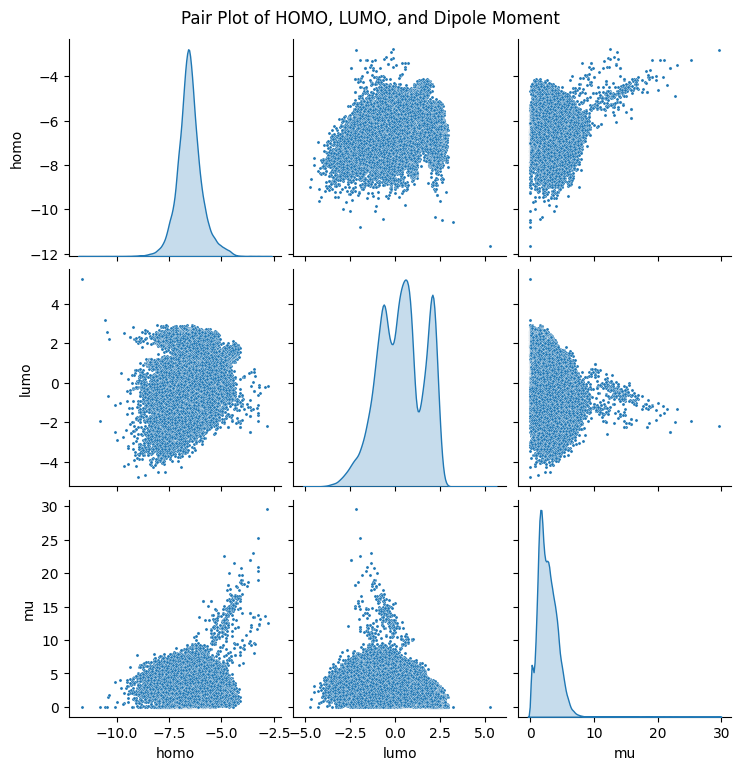

In [19]:
import seaborn as sns

# Create pair plots for a subset of properties
sns.pairplot(df[['homo', 'lumo', 'mu']], diag_kind='kde', plot_kws={"s": 5})
plt.suptitle("Pair Plot of HOMO, LUMO, and Dipole Moment", y=1.02)
plt.show()


Step 7: Inspecting Molecular Graph Structures
The QM9 dataset stores molecular graphs, where nodes represent atoms and edges represent bonds. Let's inspect the graph structure of a molecule.

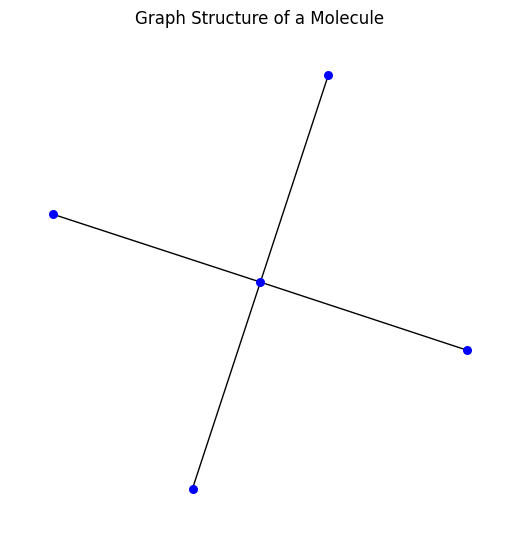

Number of atoms (nodes): 5
Number of bonds (edges): 4


In [20]:
from torch_geometric.utils import to_networkx
import networkx as nx

# Convert a PyTorch Geometric molecule graph to a NetworkX graph
molecule_graph = to_networkx(dataset[0], to_undirected=True)

# Visualize the molecular graph
plt.figure(figsize=(5, 5))
nx.draw(molecule_graph, node_size=30, node_color='blue')
plt.title("Graph Structure of a Molecule")
plt.show()

# Display number of nodes (atoms) and edges (bonds)
print(f"Number of atoms (nodes): {molecule_graph.number_of_nodes()}")
print(f"Number of bonds (edges): {molecule_graph.number_of_edges()}")


Step 8: Checking Distribution of Atomic Numbers (Elements)
We can check the distribution of atomic numbers (types of elements) across the dataset, which helps in understanding the diversity of elements in the QM9 dataset.

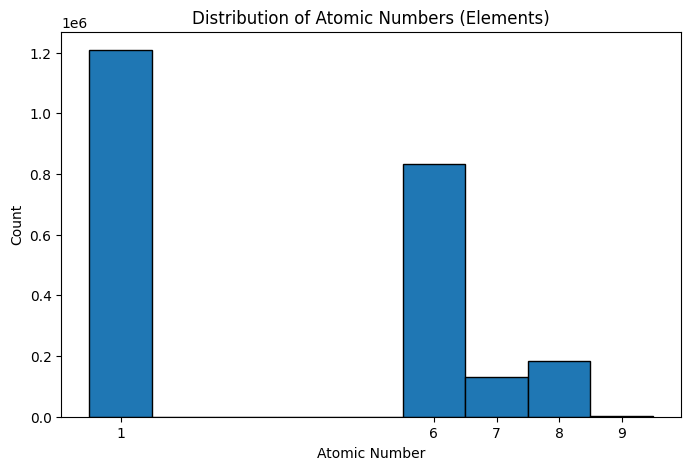

In [21]:
import numpy as np

# Collect all atomic numbers across the dataset
atomic_numbers = torch.cat([data.z for data in dataset], dim=0).numpy()

# Plot the distribution of atomic numbers
plt.figure(figsize=(8, 5))
plt.hist(atomic_numbers, bins=np.arange(min(atomic_numbers)-0.5, max(atomic_numbers)+1, 1), edgecolor='black')
plt.xticks(np.unique(atomic_numbers))
plt.xlabel('Atomic Number')
plt.ylabel('Count')
plt.title('Distribution of Atomic Numbers (Elements)')
plt.show()


Step 9: Exploratory Statistics
We can also compute some basic statistics such as mean, median, and standard deviation for various molecular properties.

In [23]:
# Summary statistics for HOMO, LUMO, and Dipole Moment
print("Summary Statistics for HOMO, LUMO, and Dipole Moment:")
print(df[['homo', 'lumo', 'mu']].describe())


Summary Statistics for HOMO, LUMO, and Dipole Moment:
                homo           lumo             mu
count  130831.000000  130831.000000  130831.000000
mean       -6.536452       0.322044       2.672953
std         0.597741       1.274855       1.503479
min       -11.662800      -4.761992       0.000000
25%        -6.873596      -0.634025       1.577800
50%        -6.560665       0.342863       2.475300
75%        -6.228686       1.385060       3.596350
max        -2.767398       5.265403      29.556400


Step 3: Loading the QM9 Dataset

In [24]:
# Load QM9 dataset
transform = Distance(norm=False)
dataset = QM9(root='data/QM9', transform=transform)

# Take a subset if you want for faster training, for example 5000 samples
dataset = dataset[:5000]

# Split the dataset into train and test sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)


/usr/local/lib/python3.10/dist-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.load(f) != _repr(self.p

Step 4: Define the GNN Encoder

In [25]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNNEncoder, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x


Step 5: Define the VAE (Variational Autoencoder)

In [26]:
class MoleculeVAE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MoleculeVAE, self).__init__()
        self.encoder = GNNEncoder(hidden_channels)
        self.fc_mu = torch.nn.Linear(hidden_channels, out_channels)
        self.fc_logvar = torch.nn.Linear(hidden_channels, out_channels)
        self.decoder = GCNConv(out_channels, in_channels)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x, edge_index):
        x = self.encoder(x, edge_index)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def forward(self, x, edge_index):
        mu, logvar = self.encode(x, edge_index)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z, edge_index)
        return x_recon, mu, logvar


Step 6: Loss Function
We'll use a combination of reconstruction loss (MSE) and the KL divergence to enforce the VAE's latent space structure.

In [27]:
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    # KL divergence
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss


Step 7: Training Loop

In [28]:
def train(model, optimizer, loader):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        recon_x, mu, logvar = model(data.x, data.edge_index)
        loss = loss_function(recon_x, data.x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


Step 8: Evaluation and Generation

In [29]:
def test(model, loader):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for data in loader:
            recon_x, mu, logvar = model(data.x, data.edge_index)
            loss = loss_function(recon_x, data.x, mu, logvar)
            total_loss += loss.item()
    return total_loss / len(loader)

# Function to generate new molecules
def generate_molecule(model, num_molecules=1):
    model.eval()
    with torch.no_grad():
        for _ in range(num_molecules):
            z = torch.randn((1, model.fc_mu.out_features))  # Generate random latent vectors
            generated_x = model.decoder(z, edge_index=None)  # Generate molecule
            # Visualize generated molecule using ASE
            atoms = Atoms(positions=generated_x.view(-1, 3).cpu().numpy(), numbers=[1] * generated_x.size(0))
            view(atoms)

# Training setup
model = MoleculeVAE(dataset.num_features, hidden_channels=64, out_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training process
for epoch in range(1, 21):
    loss = train(model, optimizer, train_loader)
    test_loss = test(model, test_loader)
    print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch: 001, Train Loss: 1.0186, Test Loss: 0.8238
Epoch: 002, Train Loss: 0.7539, Test Loss: 0.6873
Epoch: 003, Train Loss: 0.6322, Test Loss: 0.5864
Epoch: 004, Train Loss: 0.5556, Test Loss: 0.5386
Epoch: 005, Train Loss: 0.5326, Test Loss: 0.5351
Epoch: 006, Train Loss: 0.5183, Test Loss: 0.5103
Epoch: 007, Train Loss: 0.5075, Test Loss: 0.5143
Epoch: 008, Train Loss: 0.5047, Test Loss: 0.4982
Epoch: 009, Train Loss: 0.4957, Test Loss: 0.4915
Epoch: 010, Train Loss: 0.4946, Test Loss: 0.4911
Epoch: 011, Train Loss: 0.4908, Test Loss: 0.4827
Epoch: 012, Train Loss: 0.4857, Test Loss: 0.4874
Epoch: 013, Train Loss: 0.4833, Test Loss: 0.4754
Epoch: 014, Train Loss: 0.4735, Test Loss: 0.4715
Epoch: 015, Train Loss: 0.4701, Test Loss: 0.4752
Epoch: 016, Train Loss: 0.4665, Test Loss: 0.4692
Epoch: 017, Train Loss: 0.4631, Test Loss: 0.4573
Epoch: 018, Train Loss: 0.4544, Test Loss: 0.4549
Epoch: 019, Train Loss: 0.4497, Test Loss: 0.4507
Epoch: 020, Train Loss: 0.4451, Test Loss: 0.4415


Step 9: Generate New Molecules
After training, you can use the following function to generate new molecules.

In [ ]:
# Generate and visualize new molecules
generate_molecule(model, num_molecules=5)